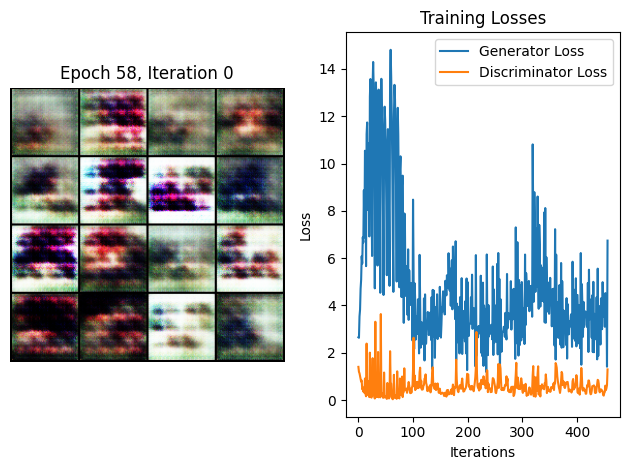

 25%|██▌       | 2/8 [00:00<00:02,  2.50it/s]

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# Set random seed for reproducibility
torch.manual_seed(42)

# Define hyperparameters
latent_dim = 100
img_size = 64
channels = 3
batch_size = 64
epochs = 200
lr = 0.0002
beta1 = 0.5

# Set up data loading
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root='D:\\Diffusion\\Training\\_datasets\\dreamweaver\\dreamweaver_cont\\backbend-chest-side', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training loop
g_losses = []
d_losses = []

# Set up the plot
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.show()

# Initialize variables for speed calculation
start_time = time.time()
steps = 0
speed = 0

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(tqdm(dataloader)):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Train discriminator
        d_optimizer.zero_grad()
        
        real_labels = torch.ones(batch_size).to(device)
        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)
        
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(z)
        fake_labels = torch.zeros(batch_size).to(device)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        g_optimizer.zero_grad()
        
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(z)
        output = discriminator(fake_images)
        g_loss = criterion(output, real_labels)
        
        g_loss.backward()
        g_optimizer.step()

        # Save losses for plotting
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        # Calculate speed
        steps += 1
        elapsed_time = time.time() - start_time
        speed = steps / elapsed_time

        # Visualize results every 50 iterations
        if i % 50 == 0:
            # Generate and visualize fake images
            with torch.no_grad():
                fake_images = generator(torch.randn(16, latent_dim, 1, 1).to(device)).cpu()

                grid = make_grid(fake_images, nrow=4, normalize=True)
                
                ax1.clear()
                ax1.imshow(grid.permute(1, 2, 0))
                ax1.axis('off')
                ax1.set_title(f"Epoch {epoch+1}, Iteration {i}")

                # Add speed and loss values to the image
                info_text = f"Speed: {speed:.2f} step/s\n"
                info_text += f"G Loss: {g_loss.item():.4f}\n"
                info_text += f"D Loss: {d_loss.item():.4f}"
                ax1.text(0, -20, info_text, fontsize=10, verticalalignment='top')

            # Plot loss curves
            ax2.clear()
            ax2.plot(g_losses, label='Generator Loss')
            ax2.plot(d_losses, label='Discriminator Loss')
            ax2.set_xlabel('Iterations')
            ax2.set_ylabel('Loss')
            ax2.legend()
            ax2.set_title('Training Losses')

            # Add current loss values to the plot
            ax2.text(0.02, 0.98, f"Current G Loss: {g_loss.item():.4f}", transform=ax2.transAxes, verticalalignment='top')
            ax2.text(0.02, 0.94, f"Current D Loss: {d_loss.item():.4f}", transform=ax2.transAxes, verticalalignment='top')

            plt.tight_layout()
            
            # Update the plot
            fig.canvas.draw()
            fig.canvas.flush_events()
            
            # Display the plot (for Jupyter notebook)
            clear_output(wait=True)
            display(fig)

    #print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

plt.ioff()
plt.show()